In [5]:
import numpy as np
import scipy.io as sio
import h5py
import tensorflow as tf
import pickle
import os
from matplotlib import pyplot as plt
import importlib
import inspect
from copy import deepcopy
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# root directory
if os.getcwd().find('/Users/svnh2') != -1:
    root_directory = '/Users/svnh2/Desktop/projects'
elif os.getcwd().find('/home/svnh') != -1:
    root_directory = '/mindhive/nklab/u/svnh'
elif os.getcwd().find('/home/svnh') != -1:
    root_directory = '/mindhive/nklab/u/svnh'
elif os.getcwd().find('/mindhive/nklab3') != -1:
    root_directory = '/mindhive/nklab/u/svnh'
else:
    raise NameError('No root directory found')
    
# external repositories that depend on the root directory
# reload, in case they've changed
import sys
sys.path.append(root_directory)
from general_analysis import misc
from general_analysis import plot

Parametric basis functions

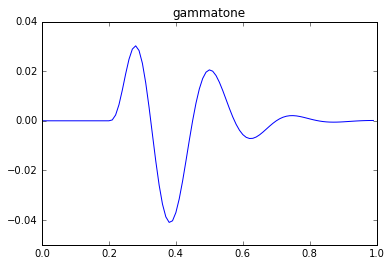

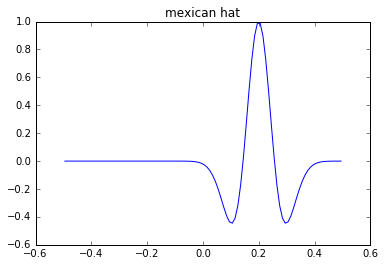

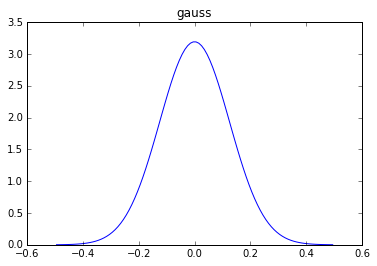

In [409]:
def gammatone(sr, win, shift, scale, rel_shift, rel_scale):

    '''Gammatone function that can be shifted and scaled
    
    If sr is the sampling rate in Hz, the best rate is 1 * 2^(scale) Hz
    and the function returns a window of win seconds
    
    shift and scale are applied first
    rel_shift and rel_scale are applied compositionally to the 
    already shifted and scaled versions
    '''
    
    N = np.int32(np.round(sr * win))
    x = np.linspace(0, 1-1/N, N)*win
    z1 = (x - rel_shift) * np.float_power(2, rel_scale)
    z2 = (z1 - shift) * np.float_power(2, scale)
    z3 = np.maximum(z2,0)
    f = (z3**2) * np.exp(-3.5*z3) * np.sin(2*np.pi*z3)
    
    return {'f': f, 'x': x}

def mexhat(sr, win, shift, scale, rel_shift, rel_scale):

    '''Mexican hat function that can be shifted and scaled
    
    If sr is the sampling rate in Hz, the best rate is 1 * 2^(scale) Hz
    and the function returns a window of -0.5 win seconds to 0.5 win seconds
    
    shift and scale are applied first
    rel_shift and rel_scale are applied compositionally to the 
    already shifted and scaled versions
    '''
    
    N = np.int32(np.round(sr * win))
    x = np.linspace(-1, 1, N)*(0.5*(N-1)/N)*win
    z1 = (x - rel_shift) * np.float_power(2, rel_scale)
    z2 = (z1 - shift) * np.float_power(2, scale)
    f = (1 - 2 * (np.pi * z2)**2) * np.exp(-(np.pi * z2)**2)
    
    return {'f': f, 'x': x}

def gauss(sr, win, shift, scale, rel_shift, rel_scale):

    '''Gaussian function that can be shifted and scaled
    
    To translate to Hz-like representation 4 std treated as a half cycle
    such that scale=0 corresponds to about 1 Hz
    
    shift and scale are applied first
    rel_shift and rel_scale are applied compositionally to the 
    already shifted and scaled versions
    '''
    sig = 1/2.355 # sig of 1 FWHM
    sig = 1/8
    N = np.int32(np.round(sr * win))
    x = np.linspace(-1, 1, N)*(0.5*(N-1)/N)*win
    z1 = (x - rel_shift) * np.float_power(2, rel_scale)
    z2 = (z1 - shift) * np.float_power(2, scale)
    f = (1/(sig * np.sqrt(2*np.pi))) * np.exp(-0.5*(z2**2)/(sig**2))
    
    return {'f': f, 'x': x}

# illustrate gammatone
sr = 100
win = 1
rel_shift = 0
rel_scale = 0
scale = 2
shift = 0.2
fx = gammatone(sr, win, shift, scale, rel_shift, rel_scale)
plt.plot(fx['x'], fx['f'])
plt.title('gammatone')
plt.show()

# illustrate mexican hat
sr = 100
win = 1
rel_shift = 0
rel_scale = -1
scale = 3
shift = 0.1
fx = mexhat(sr, win, shift, scale, rel_shift, rel_scale)
plt.plot(fx['x'], fx['f'])
plt.title('mexican hat')
plt.show()

# illustrate gaussian
sr = 100
win = 1
rel_shift = 0
rel_scale = 0
scale = 0
shift = 0
fx = gauss(sr, win, shift, scale, rel_shift, rel_scale)
plt.plot(fx['x'], fx['f'])
plt.title('gauss')
plt.ylim([0, np.max(fx['f'])*1.1])
plt.show()

Creates the parameteric 2D basis functions for STRFs

In [417]:
def param_bases(global_params, basis_params, neuron_params, n_bases, n_neurons, strf_rank, neuron_rank):
    
    n_tps = np.int32(global_params['temp_sr']*global_params['temp_win'])
    n_freq = np.int32(global_params['spec_sr']*global_params['spec_win'])
    strfs = np.zeros((n_tps, n_freq, n_neurons))
    for i in range(n_neurons):
        for j in range(neuron_rank):
            temp_basis = np.zeros((n_tps, strf_rank))
            spec_basis = np.zeros((strf_rank, n_freq))
            for k in range(strf_rank):
                for l in range(n_bases):
                    ft = global_params['temp_fn'](
                        [global_params['temp_sr'], global_params['temp_win'], 
                         basis_params['temp_shifts'][l], basis_params['temp_scales'][l], 
                         neuron_params['temp_shifts'][i], neuron_params['temp_scales'][i]])
                    fs = global_params['spec_fn'](
                        [global_params['spec_sr'], global_params['spec_win'], 
                         basis_params['spec_shifts'][l], basis_params['spec_scales'][l], 
                         neuron_params['spec_shifts'][i], neuron_params['spec_scales'][i]])
                    temp_basis[:,k] = temp_basis[:,k] + ft['f'] * basis_params['temp_weights'][l,k,j]
                    spec_basis[k,:] = spec_basis[k,:] + fs['f'] * basis_params['spec_weights'][l,k,j]
                    if l == 0 and k == 0 and j == 0 and i == 0:
                        t = ft['x']
                        s = fs['x']
                    
            strf_basis = np.matmul(temp_basis, spec_basis)
            strfs[:,:,i] = strfs[:,:,i] + strf_basis * neuron_params['weights'][j,i]
                    
    return {'f': strfs, 't': t, 's': s}

Illustrates how the STRF properties can be manipulated

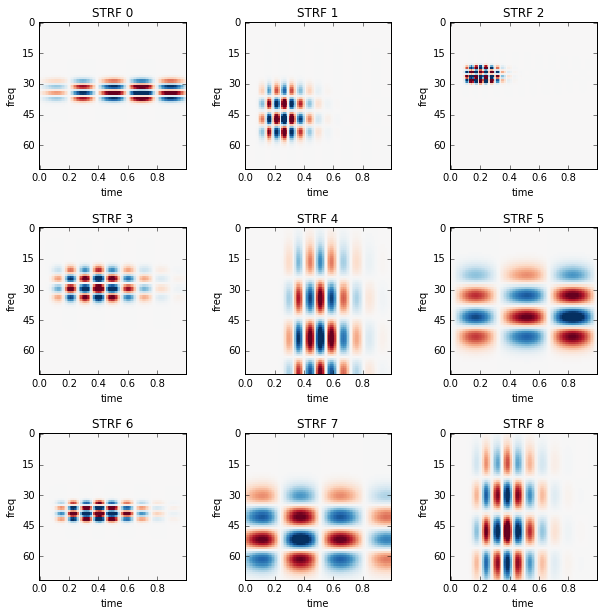

In [430]:
# number of basis strfs which can linearly combine to compose each neuron
neuron_rank = 1

# number of temporal and spectral bases which can form each strf
strf_rank = 1

# number of parameteric bases used to form each temporal and spectral basis
n_param_bases = 10

# number of neurons to sample
n_neurons = 9

# seed determining randomness
random_seed = 4
np.random.seed(random_seed)

# sampling rate, window, and basis functions in time and frequency
# note the window only partially determines the effective receptive field
# the rate parameters below have a bigger impact
global_params = {}
global_params['temp_sr'] = 100 # 100 Hz
global_params['temp_win'] = 1 # 1 second
global_params['temp_fn'] = lambda args: gammatone(*args)
global_params['spec_sr'] = 24 # 24 cyc / oct
global_params['spec_win'] = 3 # 3 octaves
global_params['spec_fn'] = lambda args: gauss(*args)

# parameters determining the bases for the neuron STRFs
basis_params = {}
basis_params['temp_shifts'] = np.random.uniform(low=-0.25, high=0.25, size=(n_param_bases,)) # 500 ms of shifts
basis_params['temp_scales'] = np.random.uniform(low=2, high=2, size=(n_param_bases,)) # fixed at 4 Hz, rate determined below
basis_params['spec_shifts'] = np.random.uniform(low=-0.5, high=0.5, size=(n_param_bases,)) # 1 octave of shifts
basis_params['spec_scales'] = np.random.uniform(low=0, high=0, size=(n_param_bases,)) # fixed at 1 cycle / octave, scale determined below
basis_params['temp_weights'] = np.random.randn(n_param_bases,strf_rank,neuron_rank) # temporal weights
basis_params['spec_weights'] = np.random.randn(n_param_bases,strf_rank,neuron_rank) # spectral weights

# parameters deteriming the actual neuron STRFs and their shifts and scales
neuron_params = {}
neuron_params['temp_shifts'] = np.random.uniform(low=0, high=0.5, size=(n_neurons,)) # 500 ms of shifts
neuron_params['temp_scales'] = np.random.uniform(low=-2, high=2, size=(n_neurons,)) # 4 octaves of scaling, 1 Hz -> 16 Hz
neuron_params['spec_shifts'] = np.random.uniform(low=-0.5, high=0.5, size=(n_neurons,)) # 1 octaves of shifts
neuron_params['spec_scales'] = np.random.uniform(low=-2, high=2, size=(n_neurons,)) # 4 octaves of scaling, 0.25 -> 4 cyc / octave
neuron_params['weights'] = np.random.randn(neuron_rank,n_neurons)

# calculate strfs
strfs = param_bases(global_params, basis_params, neuron_params, n_param_bases, n_neurons, strf_rank, neuron_rank)

# plot
figure_directory = misc.mkdir(os.getcwd() + '/param-bases')
plt.figure(figsize=(10,10))
n_cols = np.round(np.sqrt(n_neurons))
n_rows = np.ceil(n_neurons/n_cols)
for i in range(n_neurons):
    plt.subplot(n_rows, n_cols, i+1)
    plot.imshow(strfs['f'][:,:,i].transpose(), xtick_labels=strfs['t'])
    plt.xlabel('time')
    plt.ylabel('freq')
    plt.title('STRF ' + str(i))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.savefig(figure_directory + '/sample' + str(random_seed) + '.pdf')

Code below is old, but could be useful later so didn't want to delete

In [ ]:
# based Hohmann, 2002, frequency analysis and synthesis using a gammatone filterbank, eq. 1
N = 32
sr_Hz = 0.01
t = np.linspace(0, 1, N) / sr_Hz
lbda = 0.9
B = np.pi*0.05
a = lbda * np.exp(1j*B)
gam = 3
htb = t**(gam-1) * a**t

plt.plot(t, np.real(htb))
plt.plot(t, np.imag(htb))
plt.show()

# based on matlab function cgauwavf
N = 32
sr_cycoct = 1
s = np.linspace(-3, 3, N) / sr_cycoct
s2 = np.square(s)
F0 = np.exp(-s2);
F1 = np.exp(-1j*s);
F2 = (F1*F0)/np.sqrt(np.exp(-1/2)*np.sqrt(2)*np.sqrt(np.pi));
hsb = -(1/3)*F2*(-3+4*1j*s+4*s2)*np.sqrt(6);

plt.plot(s, np.real(hsb))
plt.plot(s, np.imag(hsb))
plt.show()

N = 32
t = np.linspace(-1, 1, N)
sigma = 0.3
hl = np.exp(-np.square(t/sigma)/2)
plt.plot(t, hl)
plt.show()